<a href="https://colab.research.google.com/github/datacommonsorg/api-python/blob/master/notebooks/intro_data_science/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0

# Exploring Feature Engineering

Welcome! In this lesson, we'll be exploring various techniques for feature engineering. We'll be walking through the steps one takes to set up your data for your machine learning models, starting with acquiring and exploring the data, working through different transformations and feature representation choices, and analyzing how those design decisions affect our model's results. 

## Learning Objectives:
In this lesson, we'll be covering
* Tools for data exploration and visualization
* Useful feature representations
* Useful feature transformations
* Why is feature engineering important?

### Need extra help?

If you're new to Google Colab, take a look at [this getting started tutorial](https://colab.research.google.com/notebooks/intro.ipynb).

To build more familiarity with the Data Commons API, check out these [Data Commons Tutorials](https://docs.datacommons.org/tutorials/).

And for help with Pandas and manipulating data frames, take a look at the [Pandas Documentation](https://pandas.pydata.org/docs/reference/index.html).

We'll be using the scikit-learn library for implementing our models today. Documentation can be found [here](https://scikit-learn.org/stable/modules/classes.html). 

As usual, if you have any other questions, please reach out to your course staff!


## Part 0: Introduction and Setup

As a result of the COVID-19 pandemic, we have very detailed statistics on the number of COVID-19 cases across the United States. Many studies have been done on the medical bases of the disease, but it is widely known that societal factors, like public policy, can greatly affect case numbers. Today, we'll take advantage of Data Commons, an open-source project that allows us to easily combine data from multiple different sources, to analyze the impact of social factors on COVID-19 cases. While public policy is hard to quantify into a data point, perhaps we can find other social factors that correlate with the number of COVID-19 cases.


**Our data science question:** How do various social factors (median income, household size, etc.) affect the cummulative number of COVID-19 cases?


Run the following codeboxes to install and load the packages required.

In [ ]:
# We need to install the Data Commons API, since they don't ship natively with
# most python installations.

# In Colab, we'll be installing the Data Commons python and pandas APIs through pip.

!pip install datacommons --upgrade --quiet
!pip install datacommons_pandas --upgrade --quiet

# We'll also install some nice libraries for some pretty plots
# Import the two methods from heatmap library to make pretty correlation plots
!pip install heatmapz --upgrade --quiet

In [ ]:
# Imports

# Data Commons Python and Pandas APIs
import datacommons as dc
import datacommons_pandas as dcp

# For manipulating data
import pandas as pd

# For creating a model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
from heatmap import heatmap, corrplot

## Part 1: Acquiring Data


### 1.1) Setting the Scope
As a starting point, we'll keep the scope of our analysis to the United States. Your job will be to select a state of interest and query for data at the county level, across all counties for your state of choice.

In Data Commons, every concept has a unique identifier, called a DCID, that's needed when querying for data. First, let's grab the DCIDs of all counties for your state of choice. We can use the [`get_places_in()`](https://docs.datacommons.org/api/python/place_in.html) method to list the DCIDs for all counties in your state of choice easily!

**1.1)** Choose a US state to analyze. Use the [Data Commons Graph Browser](https://datacommons.org/browser/) to find the DCID for your state of choice, then fill in the code box below with the DCID.


In [ ]:
# Choose your state:
your_state_dcid = "geoId/06" # Using California as an example # YOUR DCID HERE

# Get a list of all DCIDs for counties in that state.
county_dcids = dc.get_places_in([your_state_dcid], "County")[your_state_dcid]
print(county_dcids)

['geoId/06001', 'geoId/06003', 'geoId/06005', 'geoId/06007', 'geoId/06009', 'geoId/06011', 'geoId/06013', 'geoId/06015', 'geoId/06017', 'geoId/06019', 'geoId/06021', 'geoId/06023', 'geoId/06025', 'geoId/06027', 'geoId/06029', 'geoId/06031', 'geoId/06033', 'geoId/06035', 'geoId/06037', 'geoId/06039', 'geoId/06041', 'geoId/06043', 'geoId/06045', 'geoId/06047', 'geoId/06049', 'geoId/06051', 'geoId/06053', 'geoId/06055', 'geoId/06057', 'geoId/06059', 'geoId/06061', 'geoId/06063', 'geoId/06065', 'geoId/06067', 'geoId/06069', 'geoId/06071', 'geoId/06073', 'geoId/06075', 'geoId/06077', 'geoId/06079', 'geoId/06081', 'geoId/06083', 'geoId/06085', 'geoId/06087', 'geoId/06089', 'geoId/06091', 'geoId/06093', 'geoId/06095', 'geoId/06097', 'geoId/06099', 'geoId/06101', 'geoId/06103', 'geoId/06105', 'geoId/06107', 'geoId/06109', 'geoId/06111', 'geoId/06113', 'geoId/06115']


### 1.2) Finding Features

#### 1.2.1) Find Candidate Features
Now that we have the DCIDs of all counties for your state of interest, let's figure out what features to use!

First, let's query Data Commons for data we're interested in using the [`build_multivariate_dataframe()`](https://docs.datacommons.org/api/pandas/multivariate_dataframe.html) method.

We'll start out with the following features:

* Population
* Median Income
* Number of Households with 4 or more people

And of course, since we're analyzing COVID-19 cases, we'll query for that too.

At this stage, we're just loading in data that is potentially interesting to include in our analysis.

**1.2A)** Take a look at [this list of all Statistical Variables](https://docs.datacommons.org/statistical_variables.html). Find at least 3 more variables to add to your analysis.

_Note: not all variables are available for all locations. If you notice the dataframe has some missing columns, try a different variable!_

In [ ]:
# Create a pandas dataframe containing data for each of the features
# listed above. Your dataframe should have the states going along the rows,
# with one column per feature.

stat_vars_to_query = [
                      "CumulativeCount_MedicalTest_ConditionCOVID_19_Positive",
                      "Count_Person",
                      "Count_Person_MarriedAndNotSeparated",
                      "Median_Income_Person",
                      "Count_Household_With4OrMorePerson"
                      
]

raw_df = dcp.build_multivariate_dataframe(county_dcids, stat_vars_to_query)
display(raw_df)

,Count_Person,Count_Person_MarriedAndNotSeparated,Median_Income_Person,Count_Household_With4OrMorePerson,CumulativeCount_MedicalTest_ConditionCOVID_19_Positive
place,,,,,
geoId/06001,1656754,669429,43583,157543,73771
geoId/06003,1039,432,30512,61,74
geoId/06005,38429,17756,31160,2754,3199
geoId/06007,225817,79755,24067,17707,10177
geoId/06009,45514,19985,29124,2640,1763
geoId/06011,21454,8858,27103,2305,1935
geoId/06013,1142251,480862,42181,113092,57337
geoId/06015,27495,9727,23493,1946,883
geoId/06017,188563,88764,36682,14368,8359


#### 1.2.1) Curate Features
Now that we've got a list of candidate features, we'll need to narrow it down to the features that will be most useful for our analysis.

How do you know which features are useful? One helpful tool is to use a **correlation matrix**. You can think of a correlation as a table of values with each features in the rows and columns. The further away from zero the value in any particular cell is, the more highly correlated the feature corresponding to its row and column are.

Run the following code block to generate a correlation matrix of the features you've chosen. A larger size/darker color denotes stronger correlation.

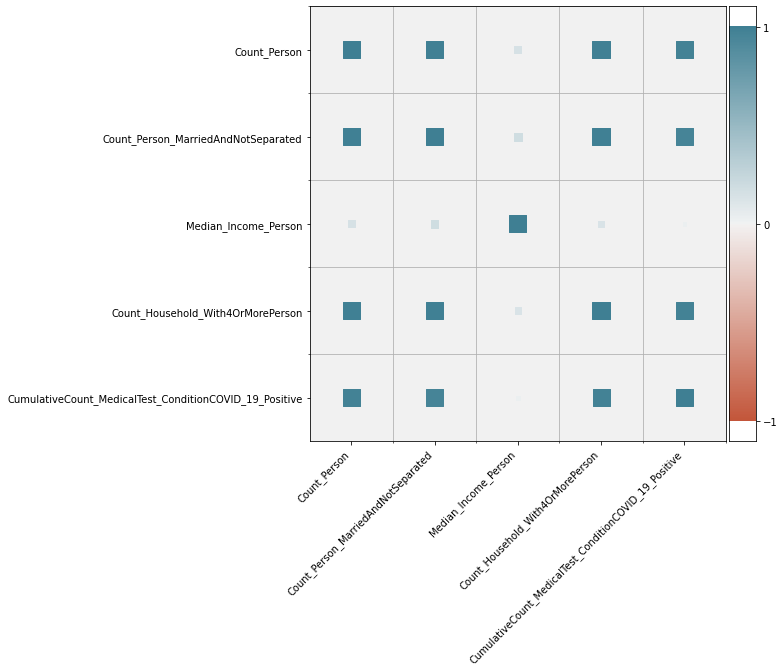

In [ ]:
# Generate a correlation matrix plot
# We'll use the heatmapz package to draw a nice one.
plt.figure(figsize=(8, 8))
corrplot(raw_df.corr(), size_scale=300);

**1.2B)** Why does the diagonal from top left to bottom right have such strong correlations?

**1.2C)** Which features correlate the most? Which features correlate the least?

**1.2D)** Which features do you think will be most useful for predicting life expectancy? Why?

**1.2E)** Do any features (life expectancy is not counted as a feature) correlate strongly with each other?

**1.2F)** If two features correlate very strongly with each other, would you want to include them both in your analysis? Why or why not?

**1.2G)** Using your answers for 1.2C - 1.2F, fill in the code box below with a filtered list of statistical variables that you think are best to use for our model. The code box will generate a new dataframe containing only our selected useful features.

In [ ]:
filtered_stat_vars_to_query = [
                              "LifeExpectancy_Person",
                              "Count_Person",
                              "Count_Person_MarriedAndNotSeparated",
                              "Median_Income_Person",
                              "Count_Household_With4OrMorePerson"
                      
]

# Get data from Data Commons
filtered_df = dcp.build_multivariate_dataframe(county_dcids, stat_vars_to_query)
display(filtered_df)


,Median_Income_Person,Count_Household_With4OrMorePerson,CumulativeCount_MedicalTest_ConditionCOVID_19_Positive,Count_Person,Count_Person_MarriedAndNotSeparated
place,,,,,
geoId/06001,43583,157543,73771,1656754,669429
geoId/06003,30512,61,74,1039,432
geoId/06005,31160,2754,3199,38429,17756
geoId/06007,24067,17707,10177,225817,79755
geoId/06009,29124,2640,1763,45514,19985
geoId/06011,27103,2305,1935,21454,8858
geoId/06013,42181,113092,57337,1142251,480862
geoId/06015,23493,1946,883,27495,9727
geoId/06017,36682,14368,8359,188563,88764


Those DCID row names are not very accessible. Let's replace them with their human-readable names, by using the [`get_property_values()`](https://docs.datacommons.org/api/python/property_value.html) method to get a mapping of each county's dcid to its name.

In [ ]:
# Produce a dictionary mapping dcids to county names
# e.g. {'dcid' : ['County Name']}
county_name_dict = dc.get_property_values(county_dcids, 'name')

# Replace DCIDs with human readable names
# Make Row Names More Readable
# --- First, we'll copy the dcids into their own column
# --- Next, we'll get the "name" property of each dcid
# --- Then add the returned dictionary to our data frame as a new column
# --- Finally, we'll set this column as the new index
df = filtered_df.copy(deep=True)
df['DCID'] = df.index
county_name_dict = {key:value[0] for key, value in county_name_dict.items()}
df['County'] = pd.Series(county_name_dict)
df.set_index('County', inplace=True)
display(df)

,Median_Income_Person,Count_Household_With4OrMorePerson,CumulativeCount_MedicalTest_ConditionCOVID_19_Positive,Count_Person,Count_Person_MarriedAndNotSeparated,DCID
County,,,,,,
Alameda County,43583,157543,73771,1656754,669429,geoId/06001
Alpine County,30512,61,74,1039,432,geoId/06003
Amador County,31160,2754,3199,38429,17756,geoId/06005
Butte County,24067,17707,10177,225817,79755,geoId/06007
Calaveras County,29124,2640,1763,45514,19985,geoId/06009
Colusa County,27103,2305,1935,21454,8858,geoId/06011
Contra Costa County,42181,113092,57337,1142251,480862,geoId/06013
Del Norte County,23493,1946,883,27495,9727,geoId/06015
El Dorado County,36682,14368,8359,188563,88764,geoId/06017


### 1.3) Data Visualization

Now that we have our features, it's time to explore the data more in depth! This step is extremely important. The more familiar we are with our data, the better models we can build, and the better equiped we will be to troubleshoot when something goes wrong.

**1.2) For each feature, generate a plot or otherwise write code to answer each of the following:**
 - What is the maximum value of the feature?
 - What is the minimum value of the feature?
 - What is the distribution of values for this feature?
 - Is the data complete? Are there any NaN or empty values?
 - Are there any strange outliers?



In [ ]:
# Use this space to create scatter plots, histograms, etc.
# to answer the questions above.

# YOUR CODE HERE

# Example Solution:

# Get some basic statistics
display(df.describe())


,Median_Income_Person,Count_Household_With4OrMorePerson,CumulativeCount_MedicalTest_ConditionCOVID_19_Positive,Count_Person,Count_Person_MarriedAndNotSeparated
count,58.000000,58.000000,5.800000e+01,5.800000e+01,5.800000e+01
mean,30963.620690,65395.879310,5.731490e+04,6.773017e+05,2.568637e+05
std,7354.083205,142739.559875,1.561510e+05,1.469524e+06,5.313952e+05
min,18245.000000,61.000000,7.400000e+01,1.039000e+03,4.320000e+02
25%,25765.500000,3339.250000,2.906500e+03,4.764675e+04,2.087950e+04
50%,29496.500000,16536.500000,1.202200e+04,1.846320e+05,7.654600e+04
75%,33250.000000,59041.250000,4.324475e+04,6.927508e+05,2.567815e+05
max,52866.000000,974692.000000,1.116948e+06,1.008157e+07,3.538490e+06


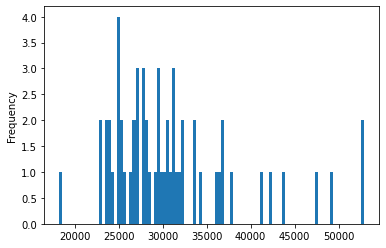

In [ ]:
# Plot histograms to get an idea of data spread
display(features_df["Median_Income_Person"].plot.hist(bins=100))


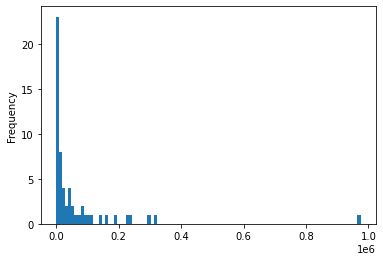

In [ ]:
display(df["Count_Household_With4OrMorePerson"].plot.hist(bins=100))


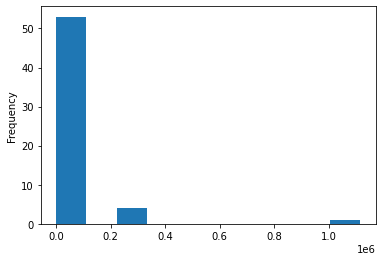

In [ ]:
display(df["CumulativeCount_MedicalTest_ConditionCOVID_19_Positive"].plot.hist(bins=10))

### 1.3) Data Cleaning
Before proceeding with our model, we first need to clean our data. Sometimes our data comes to us incomplete, with missing values, or in a different unit than we were expecting. It's always best practice to look through your data to make sure there are no corrupt, inaccurate, or missing records. If we do find such entries, we need to replace, motify, or remove that data. The process of correcting or removing bad data is known as **data cleaning**.

Some common things to look out for:
* Data can be missing (e.g. an empty cell in a column). Depending on your application and context, sometimes there's a clear "default" value that can be filled in.
* Duplicate rows or columns. You will need to delete the extras.
* The format of the data you're provided is incorrect. This can include strange naming conventions, typos, strange capitalization, or inconsistencies (e.g. having both "N/A" and "Not Applicable" appear).


**1.3A)** Why bother replacing/modifying/removing "dirty" data in the first place? What do you think would happen if we found "dirty" data, but trained a model on such data without data cleaning first?


**1.3B)**  How would you approach handling any NaN or empty values in a dataframe? Should we remove that row? Remove the feature? Or should we replace NaNs with a particular value (and if so, how do you decide what value that should be)?
 

**1.3C)**  Take a look at the dataframe outputted by the code box above from section 1.2. Are there any values that need to be cleaned? If so, write code to implement the answers to the above questions using the code box below.

_Hint: If you're strugging, check out the [Pandas documentation](https://pandas.pydata.org/docs/reference/index.html) for methods you can use to manipulate the data in the data frame._

In [ ]:
# Use this code box to implement any imputation and data cleaning.

# YOUR CODE HERE

## Part 2: Building Features

Now that we've selected and explored some features, we now need to decide how exactly to encode our data into a feature vector to feed into our model.

### 2.1) Feature Transformations

Sometimes transforming the data can reveal interesting combinations, or better scale our data. Here are some things to look out for:

* If your data has a skewed distribution or large changes in magnitude, it may be helpful to take the $log()$ of your data to bring it closer to normal. 
* Othertimes it may be helpful to bin close values together (for example, create groupings by age 0-10, 11-20, 21-30, etc.)
* When working with population or demographic data, it's often also prudent to consider whether the features you are using should be scaled by population.

**2.1) Choose a feature transformation to implement, and use it to transform at least one of your features.**

In [ ]:
# Try different transformations on your features like taking the log, binning, etc.

# YOUR CODE HERE

# Example solution:
# Data Commons often contains data already in "per capita" form, but as an exercise
# it'll be good for students to realize they should compare features like household counts
# normalized by population and do this themselves.

# Normalizing Count_HouseholdWith4OrMorePerson by population Count
household_count_percapita = df['Count_Household_With4OrMorePerson']/df['Count_Person']
household_df = household_count_percapita.to_frame()
household_df.index.name = 'place'
household_df = household_df.rename({0:'Household4orMore_percapita'}, axis=1)
features_df_new = pd.concat([household_df,df], axis=1)
display(features_df_new)


,Household4orMore_percapita,Median_Income_Person,Count_Household_With4OrMorePerson,CumulativeCount_MedicalTest_ConditionCOVID_19_Positive,Count_Person,Count_Person_MarriedAndNotSeparated,DCID
place,,,,,,,
Alameda County,0.095091,43583,157543,73771,1656754,669429,geoId/06001
Alpine County,0.058710,30512,61,74,1039,432,geoId/06003
Amador County,0.071665,31160,2754,3199,38429,17756,geoId/06005
Butte County,0.078413,24067,17707,10177,225817,79755,geoId/06007
Calaveras County,0.058004,29124,2640,1763,45514,19985,geoId/06009
Colusa County,0.107439,27103,2305,1935,21454,8858,geoId/06011
Contra Costa County,0.099008,42181,113092,57337,1142251,480862,geoId/06013
Del Norte County,0.070777,23493,1946,883,27495,9727,geoId/06015
El Dorado County,0.076197,36682,14368,8359,188563,88764,geoId/06017


### 2.2) Feature Representations
If any of your data is discrete, getting a good encoding of discrete features is particularly important. You want to create “opportunities” for your model to find the underlying regularities. 

**2.2A) For each of the following encodings, name an example of data the encoding would work well on, as well as an example of data it would not work as well for. Explain your answers.**

*  *Numeric* Assign each of these values a number, say 1.0/k, 2.0/k, . . . , 1.0. 

* *Thermometer code* Use a vector of length k binary variables, where we convert discrete input value $0 < j < k$ into a vector in which the first j values are 1.0 and the rest are 0.0.

*  *Factored code* If your discrete values can sensibly be decomposed into two parts, then it’s best to treat those as two separate features (choosing a separate encoding scheme for each).

* *One-hot code* Use a vector of length k, where we convert discrete input value $0 < j < k$ into a vector in which all values are 0.0, except for the $j$-th, which is 1.0.

**2.2B) Write a function that creates a one-hot encoding.**

In [ ]:
# Write a function that implements one-hot encoding.

# YOUR CODE HERE


### 2.3) Standardization
It is typically useful to scale numeric data, so that it tends to be in the range [−1, +1]. Without performing this transformation, if you have
one feature with much larger values than another, it will take the learning algorithm a lot of work to find parameters that can put them on an equal basis. 

Typically, we use the transformation
$$ \phi(x) = \frac{\bar{x} − x}{\sigma} $$

where $\bar{x}$ is the average of the $x_i$, and $\sigma$ is the standard
deviation of the $x_i$.

The resulting feature values will have mean 0 and standard deviation 1. This transformation is sometimes called *standardizing* a variable.

**2.3) Write code to standardize each of the features in your dataframe.**

In [ ]:
# Create a new dataframe with each of the features standardized.

# YOUR CODE HERE

# Solution:
standardized_df = (features_df_new - features_df_new.mean())/features_df_new.std()
display(standardized_df)

,Count_Household_With4OrMorePerson,Count_Person,Count_Person_MarriedAndNotSeparated,CumulativeCount_MedicalTest_ConditionCOVID_19_Positive,DCID,Household4orMore_percapita,Median_Income_Person
place,,,,,,,
Alameda County,0.645561,0.666510,0.776381,0.105386,NaN,0.460693,1.715969
Alpine County,-0.457721,-0.460192,-0.482563,-0.366574,NaN,-1.388326,-0.061411
Amador County,-0.438854,-0.434748,-0.449962,-0.346561,NaN,-0.729940,0.026703
Butte County,-0.334097,-0.307232,-0.333290,-0.301874,NaN,-0.386960,-0.937795
Calaveras County,-0.439653,-0.429927,-0.445768,-0.355758,NaN,-1.424216,-0.250150
Colusa County,-0.442000,-0.446299,-0.466707,-0.354656,NaN,1.088253,-0.524963
Contra Costa County,0.334148,0.316394,0.421529,0.000142,NaN,0.659751,1.525327
Del Norte County,-0.444515,-0.442188,-0.465072,-0.361393,NaN,-0.775077,-1.015847
El Dorado County,-0.357489,-0.332583,-0.316337,-0.313516,NaN,-0.499570,0.777579


## Part 3: Testing Your Features


Now, let's see how well a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) can learn to predict the cummulative number of COVID-19 cases, given our features.

In [ ]:
# Run me!

# Convert Dataframes into data and labels for the model
target_df = standardized_df
X = target_df[['Household4orMore_percapita','Median_Income_Person']]
Y = target_df[['CumulativeCount_MedicalTest_ConditionCOVID_19_Positive']]

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Fit an OLS linear regression model
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
print('Model Intercept: {}'.format(model.intercept_))
print('Model Coefficients: {}'.format(model.coef_))

Model Intercept: [0.01562292]
Model Coefficients: [[0.21038206 0.08063848]]


Let's now see how accurate our model was on our test set.

In [ ]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

print('Training Error: {}'.format(mse(train_pred, y_train)))
print('Test Error: {}'.format(mse(test_pred, y_test)))


Training Error: 1.1252156802381956
Test Error: 0.19184932363718019



**3) Answer the following questions.**

1. Which feature was most important (had the most weight) for your model?

2. How accurate was your model? Were any of the results surprising?

3. Rerun the code in Part 2, this time choosing different feature representations. List which feature representations you try here.

4. How do the different representations affect the resulting predictions? Which seem to work best?  Which were worse?

5. Can you think of any other factors that might affect the number of covid-19 cases that we were not able to include in the model?
